In [140]:
# the following code lines are necessary to import custom module
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import boto3
import io
import json
import numpy as np
import pandas as pd
from scipy import stats
from src.preprocessing.feature_engineer import get_wind_components, resample_data, feature_engineer

In [141]:
def get_timestamp(df):
    df["#HR_int"] = df["#HR"].astype(int).astype(str).str.zfill(2)
    df["date"] = pd.to_datetime(df["Year"] * 1000 + df["YD"], format="%Y%j").astype(str)
    df["datetime"] = df["date"] + " " + df["#HR_int"] + ":00:00"
    df["timestamp"] = pd.to_datetime(df["datetime"])
    df = df.drop(["#HR_int", "date", "datetime"], axis=1)
    return df

In [142]:
def statistical_test(sample_a, sample_b):
    w, pvalue_shapiro_a = stats.shapiro(sample_a)
    w, pvalue_shapiro_b = stats.shapiro(sample_b)
    threshold_shapiro = 0.05
    if (pvalue_shapiro_a > threshold_shapiro) & (pvalue_shapiro_b > threshold_shapiro):
        statistic, pvalue = stats.ttest_ind(sample_a, sample_b)
        if pvalue > 0.05:
            output = f"T-test: p-value: {pvalue}. Samples have same distribution, then not reject null hypothesis (H0)"
        else:
            output = f"T-test: p-value: {pvalue}. Samples are different, then reject null hypothesis (H0)"
    else:
        statistic, pvalue = stats.mannwhitneyu(sample_a, sample_b)
        if pvalue > 0.05:
            output = f"Mann-Whitney: p-value: {pvalue}. Samples have same distribution, then not reject null hypothesis (H0)"
        else:
            output = f"Mann-Whitney: p-value: {pvalue}. Samples are different, then reject null hypothesis (H0)"
    return (statistic, pvalue, output)

In [143]:
# AWS credentials to read files on S3 bucket
f = open('../credentials.json')
credentials = json.load(f)

s3_client = boto3.client(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

s3_resource = boto3.resource(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

In [144]:
# get IAG .dat data from S3 bucket
prefix_objs = s3_resource.Bucket("iag-usp").objects.filter(Prefix=f"raw/")
keys = [obj.key for obj in prefix_objs]
print(keys)

['raw/', 'raw/ITU_2017.dat', 'raw/PR40_IT_17.DAT', 'raw/SFZ_2017.dat', 'raw/SFZe_2017.dat']


In [145]:
obj = s3_client.get_object(Bucket="iag-usp", Key="raw/ITU_2017.dat")
ITU_2017 = pd.read_csv(io.BytesIO(obj["Body"].read()), sep="\s+")
ITU_2017

,#HR,YD,Year,T_CS215(C),RH_CS215(%),WS_034B(ms),WD_034B(degree),NetRL1(Wm2),Precip(mm)
0,0.000,1,2017,20.27,100.0,0.859,58.57,18.766,0.0
1,0.083,1,2017,20.33,100.0,1.034,70.04,20.074,0.0
2,0.167,1,2017,20.36,100.0,1.085,70.52,20.942,0.0
3,0.250,1,2017,20.39,100.0,1.084,69.76,21.190,0.0
4,0.333,1,2017,20.43,100.0,1.260,73.69,21.465,0.0
...,...,...,...,...,...,...,...,...,...
98781,23.250,365,2017,19.31,99.0,0.551,334.30,48.107,0.0
98782,23.333,365,2017,19.26,99.2,0.130,287.80,47.749,0.0
98783,23.417,365,2017,19.19,99.2,0.745,322.80,47.680,0.0
98784,23.500,365,2017,19.21,99.2,0.999,355.30,45.325,0.0


In [146]:
ITU_2017_metadata = {
    "#HR": "hour",
    "YD": "Day of the year",
    "Year": "Year",
    "T_CS215(C)": "Air temperature in Celsius",
    "RH_CS215(%)": "Percentual relative humidity",
    "WS_034B(ms)": "Wind speed in m/s",
    "WD_034B(degree)": "Wind direction in degrees",
    "NetRL1(Wm2)": "Net radiation in Watt/m²",
    "Precip(mm)": "Precipitation in mm"
}

In [147]:
ITU_2017 = get_timestamp(df=ITU_2017)
ITU_2017["station"] = ""
ITU_2017["station_name"] = "Itupeva"
ITU_2017 = ITU_2017.drop(["#HR", "YD", "Year"], axis=1)
ITU_2017.columns = ["temperature", "relative_humidity", "wind_velocity", "wind_direction", "radiation", "precipitation", "timestamp", "station", "station_name"]

ITU_2017 = get_wind_components(
    df=ITU_2017, 
    wind_velocity="wind_velocity", 
    wind_direction="wind_direction", 
    x_name="wind_velocity_x", 
    y_name="wind_velocity_y"
    )

ITU_2017 = ITU_2017.drop(["wind_velocity", "wind_direction"], axis=1)
ITU_2017 = resample_data(ITU_2017)
ITU_2017

/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(rule="60min").mean()


,temperature,relative_humidity,radiation,precipitation,wind_velocity_x,wind_velocity_y,station,station_name
timestamp,,,,,,,,
2017-01-01 00:00:00,20.287500,100.000000,23.491417,0.000000,0.230463,0.690697,,Itupeva
2017-01-01 01:00:00,20.059167,100.000000,32.577167,0.000000,0.252110,0.396673,,Itupeva
2017-01-01 02:00:00,19.351667,100.000000,32.335333,0.000000,-0.183269,-0.162298,,Itupeva
2017-01-01 03:00:00,19.265833,100.000000,37.048417,0.000000,0.428380,0.355938,,Itupeva
2017-01-01 04:00:00,19.806667,100.000000,44.944667,0.000000,0.417090,0.218308,,Itupeva
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,22.016667,89.383333,32.250083,0.000000,2.162629,-0.452990,,Itupeva
2017-12-31 20:00:00,21.051667,91.800000,22.436833,0.021167,2.186440,-0.885748,,Itupeva
2017-12-31 21:00:00,19.840000,97.458333,31.770500,0.000000,0.865269,-0.284581,,Itupeva


In [148]:
obj = s3_client.get_object(Bucket="iag-usp", Key="raw/PR40_IT_17.DAT")
PR40_IT_17 = pd.read_csv(io.BytesIO(obj["Body"].read()), sep="\s+")
PR40_IT_17.head()

,0.441,930.586,10.583,44,2017,9
0,0.444,930.584,10.667,44,2017,9
1,0.448,930.568,10.750,44,2017,9
2,0.455,915.193,10.917,44,2017,9
3,0.458,930.608,11.000,44,2017,9
4,0.462,930.627,11.083,44,2017,9


In [149]:
obj = s3_client.get_object(Bucket="iag-usp", Key='raw/SFZ_2017.dat')
SFZ_2017 = pd.read_csv(io.BytesIO(obj["Body"].read()), sep="\s+")
SFZ_2017.head()

,#HR,YD,Year,T_CS215(C),RH_CS215(%),WS_034B(ms),WD_034B(degree),NetRL1(Wm2),Precip(mm),WS_CSAT(m/s),WD_CSAT(degree)
0,0.083,1,2017,23.07,81.0,3.036,12.98,39.439,0.0,3.104,28.009
1,0.167,1,2017,23.07,81.1,2.820,15.94,39.170,0.0,2.690,31.425
2,0.250,1,2017,23.08,81.1,2.382,9.84,39.085,0.0,2.543,23.273
3,0.333,1,2017,23.08,81.1,1.980,9.10,39.528,0.0,0.910,350.112
4,0.417,1,2017,23.06,81.1,1.478,11.21,40.063,0.0,2.021,21.471


In [150]:
SFZ_2017_metadata = {
    "#HR": "hour",
    "YD": "Day of the year",
    "Year": "Year",
    "T_CS215(C)": "Air temperature in Celsius",
    "RH_CS215(%)": "Percentual relative humidity",
    "WS_034B(ms)": "Wind speed in m/s",
    "WD_034B(degree)": "Wind direction in degrees",
    "NetRL1(Wm2)": "Net radiation in Watt/m²",
    "Precip(mm)": "Precipitation in mm",
    "WS_CSAT(m/s)": "Wind speed in m/s",
    "WD_CSAT(degree)": "Wind direction in degrees"
}

In [151]:
SFZ_2017 = get_timestamp(df=SFZ_2017)
SFZ_2017["station"] = ""
SFZ_2017["station_name"] = "Secretaria da Fazenda"
SFZ_2017 = SFZ_2017.drop(["#HR", "YD", "Year", "WS_CSAT(m/s)", "WD_CSAT(degree)"], axis=1)
SFZ_2017.columns = ["temperature", "relative_humidity", "wind_velocity", "wind_direction", "radiation", "precipitation", "timestamp", "station", "station_name"]

SFZ_2017 = get_wind_components(
    df=SFZ_2017, 
    wind_velocity="wind_velocity", 
    wind_direction="wind_direction", 
    x_name="wind_velocity_x", 
    y_name="wind_velocity_y"
    )

SFZ_2017 = SFZ_2017.drop(["wind_velocity", "wind_direction"], axis=1)
SFZ_2017 = resample_data(SFZ_2017)
SFZ_2017

/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(rule="60min").mean()


,temperature,relative_humidity,radiation,precipitation,wind_velocity_x,wind_velocity_y,station,station_name
timestamp,,,,,,,,
2017-01-01 00:00:00,23.073636,81.027273,41.752727,0.0,1.780787,0.379479,,Secretaria da Fazenda
2017-01-01 01:00:00,23.055000,81.150000,48.428000,0.0,1.233386,-0.306264,,Secretaria da Fazenda
2017-01-01 02:00:00,22.164167,85.400000,49.107750,0.0,3.225686,1.165284,,Secretaria da Fazenda
2017-01-01 03:00:00,21.601667,88.800000,53.603083,0.0,2.150375,0.419138,,Secretaria da Fazenda
2017-01-01 04:00:00,21.339167,91.016667,54.028667,0.0,1.688457,-0.172307,,Secretaria da Fazenda
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,21.260000,90.983333,32.166750,0.0,-0.288909,-5.399918,,Secretaria da Fazenda
2017-12-31 20:00:00,20.889167,91.475000,33.810333,0.0,-0.506821,-4.436772,,Secretaria da Fazenda
2017-12-31 21:00:00,20.679167,92.800000,40.501417,0.0,-0.134269,-5.604834,,Secretaria da Fazenda


In [152]:
obj = s3_client.get_object(Bucket="iag-usp", Key="raw/SFZe_2017.dat")
SFZe_2017 = pd.read_csv(io.BytesIO(obj["Body"].read()), sep="\s+")
SFZe_2017.head()

,#HR,YD,Year,SW_CMP3(Wm2),T_GMX(C),RH_GMX(%),P_GMX(mb),WD_GMX(degree),WS_GMX(ms),T_CS215_e(C),RH_CS215_e(%)
0,0.000,1,2017,0.0,25.232,67.00,931.053,260.267,0.915,24.599,68.72
1,0.083,1,2017,0.0,25.365,66.47,930.980,233.200,1.017,24.757,68.32
2,0.167,1,2017,0.0,25.623,65.73,930.900,227.467,0.832,25.102,67.09
3,0.250,1,2017,0.0,25.643,65.40,930.880,206.333,0.593,25.092,67.15
4,0.333,1,2017,0.0,25.787,65.07,930.793,152.267,0.867,25.142,67.01


In [153]:
SFZe_2017_metadata = {
    "#HR": "hour",
    "YD": "Day of the year",
    "Year": "Year",
    "SW_CMP3(Wm2)": "Net radiation in Watt/m²",
    "T_GMX(C)": "Air temperature in Celsius",
    "RH_GMX(%)": "Percentual relative humidity",
    "P_GMX(mb)": "Atmospheric pressure in millibars (or hPa)",
    "WD_GMX(degree)": "Wind direction in degrees",
    "WS_GMX(ms)": "Wind speed in m/s",
    "T_CS215_e(C)": "Air temperature in Celsius (same as T_GMX, but the data provider says this one is more reliable)",
    "RH_CS215_e(%)": "Percentual relative humidity (same as RH_GMX(%), but the data provider says this one is more reliable)"
}

In [154]:
SFZe_2017 = get_timestamp(df=SFZe_2017)
SFZe_2017["station"] = ""
SFZe_2017["station_name"] = "Secretaria da Fazenda"
SFZe_2017 = SFZe_2017.drop(["#HR", "YD", "Year", "T_GMX(C)", "RH_GMX(%)"], axis=1)
SFZe_2017.columns = ["radiation", "pressure", "wind_direction", "wind_velocity", "temperature", "relative_humidity", "timestamp", "station", "station_name"]

SFZe_2017 = get_wind_components(
    df=SFZe_2017, 
    wind_velocity="wind_velocity", 
    wind_direction="wind_direction", 
    x_name="wind_velocity_x", 
    y_name="wind_velocity_y"
    )

SFZe_2017 = SFZe_2017.drop(["wind_velocity", "wind_direction"], axis=1)
SFZe_2017 = resample_data(SFZe_2017)
SFZe_2017

/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(rule="60min").mean()


,radiation,pressure,temperature,relative_humidity,wind_velocity_x,wind_velocity_y,station,station_name
timestamp,,,,,,,,
2017-01-01 00:00:00,0.000000,930.730417,25.479333,65.761667,-0.572460,-0.502994,,Secretaria da Fazenda
2017-01-01 01:00:00,0.000000,930.299500,25.476250,65.738333,-0.427756,-0.664884,,Secretaria da Fazenda
2017-01-01 02:00:00,0.000000,930.094000,24.139750,71.585000,-0.684951,-0.532177,,Secretaria da Fazenda
2017-01-01 03:00:00,0.000000,929.842167,23.395167,75.652500,-0.667442,-0.333730,,Secretaria da Fazenda
2017-01-01 04:00:00,0.000000,929.891167,23.293333,77.295000,-0.577988,-0.138512,,Secretaria da Fazenda
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,0.000000,928.721667,23.035250,78.684167,-1.061531,-0.301017,,Secretaria da Fazenda
2017-12-31 20:00:00,0.000000,928.702583,22.960500,77.788333,-0.902790,-0.381768,,Secretaria da Fazenda
2017-12-31 21:00:00,0.000000,928.841750,22.707250,79.067500,-1.062014,0.111403,,Secretaria da Fazenda


In [155]:
# get CGE data from S3 bucket
prefix_objs = s3_resource.Bucket("cge").objects.filter(Prefix=f"processed/")
keys = [obj.key for obj in prefix_objs]
print(keys)

['processed/', 'processed/jabaquara.csv', 'processed/lapa.csv', 'processed/parelheiros.csv', 'processed/penha.csv', 'processed/pirituba.csv', 'processed/se.csv']


In [156]:
obj = s3_client.get_object(Bucket="cge", Key="processed/se.csv")
cge_se = pd.read_csv(io.BytesIO(obj["Body"].read()))
cge_se = cge_se[(cge_se.timestamp >= "2017-01-01") & (cge_se.timestamp <= "2017-12-31")]

cge_se = cge_se[[
    "timestamp",
    "temperature",
    "precipitation_lag_1H",
    "relative_humidity_lag_1H",
    "pressure_lag_1H",
    "wind_velocity_x_lag_1H",
    "wind_velocity_y_lag_1H"
    ]]

for i in ["precipitation_lag_1H", "relative_humidity_lag_1H", "pressure_lag_1H", "wind_velocity_x_lag_1H", "wind_velocity_y_lag_1H"]:
    cge_se[i] = cge_se[i].shift(periods=1)

cge_se.columns = ["timestamp", "temperature", "precipitation", "relative_humidity", "pressure", "wind_velocity_x", "wind_velocity_y"]
cge_se = cge_se.dropna()
cge_se

,timestamp,temperature,precipitation,relative_humidity,pressure,wind_velocity_x,wind_velocity_y
59862,2017-01-01 01:00:00,24.189667,2.25,69.357833,921.090000,0.784872,0.151915
59863,2017-01-01 02:00:00,23.773500,2.25,71.334667,921.683333,0.649413,-0.248786
59864,2017-01-01 03:00:00,24.005167,2.25,76.447667,921.705000,0.367719,0.224477
59865,2017-01-01 04:00:00,23.988000,2.25,78.071500,921.436667,0.222010,-0.162305
59866,2017-01-01 05:00:00,23.627500,2.25,77.269667,920.588333,1.186828,0.460458
...,...,...,...,...,...,...,...
68592,2017-12-30 19:00:00,21.305833,0.00,83.963500,915.665000,4.801229,-0.358582
68593,2017-12-30 20:00:00,21.490667,0.00,87.734667,915.636667,4.365768,-0.369685
68594,2017-12-30 21:00:00,21.236833,0.00,92.428500,915.623333,2.620911,0.087802
68595,2017-12-30 22:00:00,21.225167,0.00,92.229333,915.301667,3.786710,-0.438438


In [157]:
obj = s3_client.get_object(Bucket="cge", Key="processed/parelheiros.csv")
cge_parelheiros = pd.read_csv(io.BytesIO(obj["Body"].read()))
cge_parelheiros = cge_parelheiros[(cge_parelheiros.timestamp >= "2017-01-01") & (cge_parelheiros.timestamp <= "2017-12-31")]

cge_parelheiros = cge_parelheiros[[
    "timestamp",
    "temperature",
    "precipitation_lag_1H",
    "relative_humidity_lag_1H",
    "pressure_lag_1H",
    "wind_velocity_x_lag_1H",
    "wind_velocity_y_lag_1H"
    ]]

for i in ["precipitation_lag_1H", "relative_humidity_lag_1H", "pressure_lag_1H", "wind_velocity_x_lag_1H", "wind_velocity_y_lag_1H"]:
    cge_parelheiros[i] = cge_parelheiros[i].shift(periods=1)

cge_parelheiros.columns = ["timestamp", "temperature", "precipitation", "relative_humidity", "pressure", "wind_velocity_x", "wind_velocity_y"]
cge_parelheiros = cge_parelheiros.dropna()
cge_parelheiros

,timestamp,temperature,precipitation,relative_humidity,pressure,wind_velocity_x,wind_velocity_y
38431,2017-01-01 01:00:00,21.049167,12.500000,99.993000,923.621667,-0.250483,-0.009588
38432,2017-01-01 02:00:00,21.106167,12.500000,99.765333,923.775000,0.000000,0.000000
38433,2017-01-01 03:00:00,21.413167,12.500000,99.854833,924.293333,0.000000,0.000000
38434,2017-01-01 04:00:00,20.844333,12.500000,99.132500,923.686667,-0.278901,0.331349
38435,2017-01-01 05:00:00,20.683167,12.500000,92.677000,923.328333,-0.084655,0.582405
...,...,...,...,...,...,...,...
47161,2017-12-30 19:00:00,20.386000,0.500000,99.993000,919.071667,-0.328288,2.177562
47162,2017-12-30 20:00:00,20.398000,1.875000,99.993000,918.570000,0.222265,1.709017
47163,2017-12-30 21:00:00,20.458167,6.208333,99.993000,918.693333,-0.023338,0.490170
47164,2017-12-30 22:00:00,20.199667,6.750000,99.993000,917.915000,-0.560905,1.344059


# Analysis

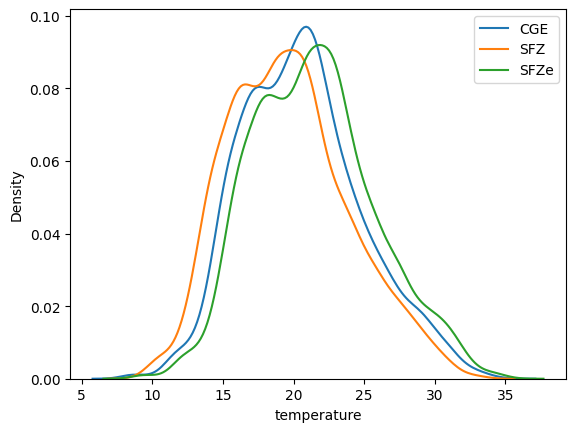

temperature: CGE Sé X SFZ
          sample_a     sample_b
count  8089.000000  8089.000000
mean     20.536693    19.600963
std       4.236737     4.299246
min      10.004000     8.985833
25%      17.331167    16.330000
50%      20.226667    19.294167
75%      23.125833    22.287500
max      35.028333    33.535000
Mann-Whitney: p-value: 2.8205773266004087e-42. Samples are different, then reject null hypothesis (H0)
 
temperature: CGE Sé X SFZe
          sample_a     sample_b
count  8730.000000  8730.000000
mean     20.570363    21.429460
std       4.276613     4.325759
min       7.855667     8.646583
25%      17.383000    18.139854
50%      20.364250    21.237833
75%      23.185292    24.154021
max      35.028333    35.583167
Mann-Whitney: p-value: 1.4196473764044642e-39. Samples are different, then reject null hypothesis (H0)
 


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


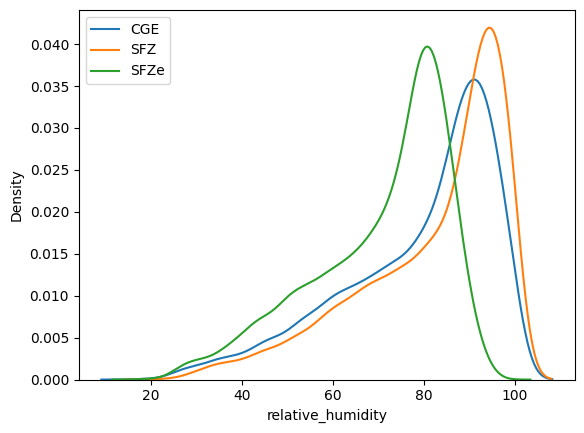

relative_humidity: CGE Sé X SFZ
          sample_a     sample_b
count  8089.000000  8089.000000
mean     78.732911    81.908739
std      16.907583    16.172367
min      17.407833    22.250833
25%      68.438167    72.225833
50%      84.327667    87.800000
75%      91.759167    94.491667
max      99.993000   100.000000
Mann-Whitney: p-value: 8.391483287079932e-50. Samples are different, then reject null hypothesis (H0)
 
relative_humidity: CGE Sé X SFZe
          sample_a     sample_b
count  8730.000000  8730.000000
mean     78.764268    70.356287
std      16.802560    14.940558
min      17.407833    18.827500
25%      68.504375    60.800417
50%      84.205167    74.970833
75%      91.735958    81.765417
max      99.993000    96.125000
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)
 


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


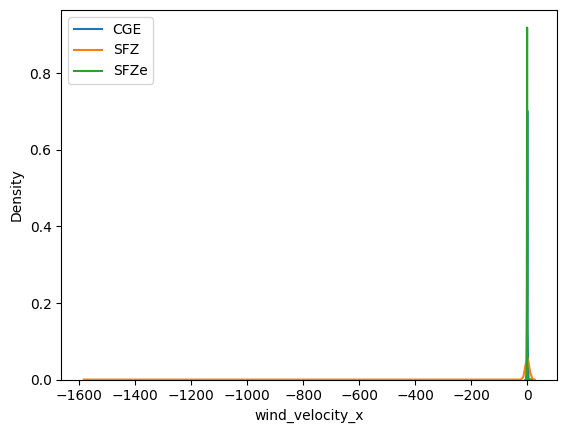

wind_velocity_x: CGE Sé X SFZ
          sample_a     sample_b
count  8089.000000  8089.000000
mean     -0.039202    -2.537842
std       1.204006    39.299038
min      -5.079736 -1564.188216
25%      -0.621805    -1.772518
50%       0.000000    -0.295566
75%       0.357511     1.442912
max       5.786345     6.972439
Mann-Whitney: p-value: 3.247811049115639e-10. Samples are different, then reject null hypothesis (H0)
 
wind_velocity_x: CGE Sé X SFZe
          sample_a     sample_b
count  8730.000000  8730.000000
mean     -0.015420    -1.050461
std       1.217108     0.528442
min      -5.079736    -5.628780
25%      -0.614869    -1.338068
50%       0.000000    -0.954181
75%       0.407333    -0.686005
max       5.786345    13.772254
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)
 


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


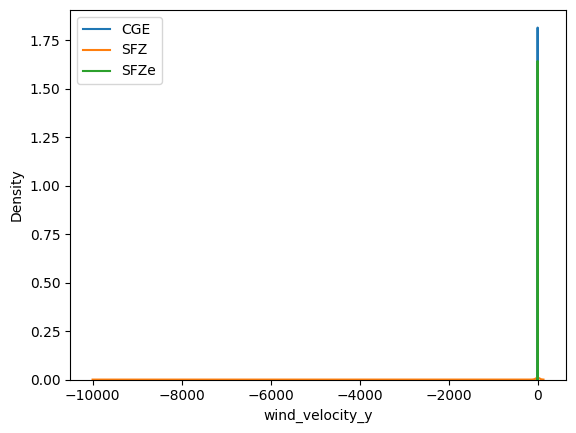

wind_velocity_y: CGE Sé X SFZ
          sample_a     sample_b
count  8089.000000  8089.000000
mean     -0.231613   -13.536668
std       0.530287   247.922356
min      -4.295853 -9875.895718
25%      -0.432908    -0.563049
50%      -0.031447     2.001407
75%       0.000000     3.927165
max       1.983481     8.919590
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)
 
wind_velocity_y: CGE Sé X SFZe
          sample_a     sample_b
count  8730.000000  8730.000000
mean     -0.228527    -0.424694
std       0.538492     0.328308
min      -4.295853   -17.013821
25%      -0.433982    -0.576065
50%      -0.026493    -0.406353
75%       0.002880    -0.250752
max       1.983481     0.501763
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)
 


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in ["temperature", "relative_humidity", "wind_velocity_x", "wind_velocity_y"]:
    try:
        sns.kdeplot(cge_se[i], label="CGE")
        sns.kdeplot(SFZ_2017[i], label="SFZ")
        sns.kdeplot(SFZe_2017[i], label="SFZe")
        plt.legend()
        plt.show()

        sample_A = cge_se[["timestamp", i]].rename(columns={i: "sample_a"})
        sample_A["timestamp"] = sample_A["timestamp"].astype(str)

        sample_B = SFZ_2017[[i]].rename(columns={i: "sample_b"})
        sample_B = sample_B.reset_index()
        sample_B["timestamp"] = sample_B["timestamp"].astype(str)

        df = sample_A.merge(sample_B, on="timestamp").dropna()

        print(f"{i}: CGE Sé X SFZ")
        print(df.drop("timestamp", axis=1).describe())
        print(statistical_test(sample_a=df.sample_a, sample_b=df.sample_b)[2])

        sample_B = SFZe_2017[[i]].rename(columns={i: "sample_b"})
        sample_B = sample_B.reset_index()
        sample_B["timestamp"] = sample_B["timestamp"].astype(str)
        
        print(" ")
        
        print(f"{i}: CGE Sé X SFZe")
        df = sample_A.merge(sample_B, on="timestamp").dropna()
        print(df.drop("timestamp", axis=1).describe())
        print(statistical_test(sample_a=df.sample_a, sample_b=df.sample_b)[2])

        print(" ")
    except:
        pass